In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import json
import torch

In [23]:
root_path = '/home/gene/Documents/Senti/AI-Detector'
dataset_path = os.path.join(root_path, 'ExampleData/Comment')
word_entropy_path = os.path.join(root_path, 'WordData')

human_data_list = json.load(open(os.path.join(dataset_path, 'human_comment_list.json'), 'r'))
gpt_data_list = json.load(open(os.path.join(dataset_path, 'GPT_comment_list.json'), 'r'))
glm_data_list = json.load(open(os.path.join(dataset_path, 'GLM_comment_list.json'), 'r'))

training_data_list = human_data_list + gpt_data_list

RawTexts = [{'comment': data_item['comment']} for data_item in training_data_list]


In [37]:
# import numpy as np
# # sum word occur number
# total_word_occur_num = sum([x[1] for x in sorted_word_list])
# # word entropy: -log(p) = -log(occur_num / total_word_occur_num)
# word_entropy_dict = {x[0]: np.log2(x[1] / total_word_occur_num) for x in sorted_word_list}
# # add special token
# word_entropy_dict['<pad>'] = -22
# word_entropy_dict['<unk>'] = -22
# json.dump(word_entropy_dict, open(os.path.join(word_entropy_path, 'JiebaEntropy/word_entropy_dict.json'), 'w'), ensure_ascii = False)

In [26]:
# # LTP entropy
# import numpy as np
# # sum word occur number
# sorted_word_list = json.load(open(os.path.join(word_entropy_path, 'LTPEntropy/sorted_word_list.json'), 'r'))
# total_word_occur_num = sum([x[1] for x in sorted_word_list])
# # word entropy: -log(p) = -log(occur_num / total_word_occur_num)
# word_entropy_dict = {x[0]: np.log2(x[1] / total_word_occur_num) for x in sorted_word_list}
# # add special token
# word_entropy_dict['<pad>'] = -22
# word_entropy_dict['<unk>'] = -22
# json.dump(word_entropy_dict, open(os.path.join(word_entropy_path, 'LTPEntropy/word_entropy_dict.json'), 'w'), ensure_ascii = False)

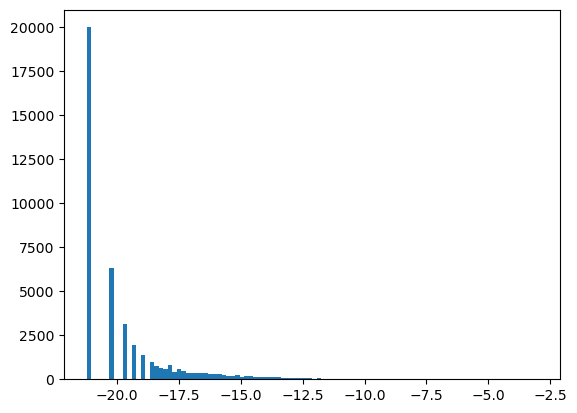

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt

# # word entropy
# word_prob = json.load(open(os.path.join(word_entropy_path, 'JiebaEntropy/word_entropy_dict.json')))
# sorted_word_list = json.load(open(os.path.join(word_entropy_path, 'JiebaEntropy/sorted_word_list.json')))

# word_occur_num = [x[1] for x in sorted_word_list]
# word_occur_num = np.log2(np.array(word_occur_num)/sum(word_occur_num))
# hist = plt.hist(word_occur_num, bins=100)

In [26]:
# gpt2 for prelexity features
from transformers import AutoTokenizer, AutoModelForCausalLM
gpt2_path = '/data/pretrained/gpt2-chinese'
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_path)
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_path) # CausalLM最后有线性层，hidden_size->vocab_size的映射，gpt2-large为(1280, 50257), gpt2-chinese为（768, 21128)
gpt2_model = gpt2_model.cuda()

In [39]:
print(human_data_list[0])

{'comment': '这个牌子的糯玉米?，买了几次了，个头大份量足，味道好有口感，一次蒸一根就可以了，搞活动优惠价买的，挺划算的，东北发货，几天才收到', 'product': '玉米', 'label': 'human'}


In [40]:
# 调用模型计算perplexity，使用gpt2的loss，即负对数似然，越小越好
def sent_scoring(model, tokenizer, text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to('cuda')
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    sentence_prob = loss.item()
    return sentence_prob

def model_infer(model, tokenizer, dataset):
    ModelScores = []
    for i in range(len(dataset)):
        score = {}
        data = dataset[i]
        score['comment_score'] = sent_scoring(model, tokenizer, data['comment'])
        score['label'] = data['label']
        ModelScores.append(score)
    return ModelScores
GPTScores = model_infer(gpt2_model, gpt2_tokenizer, human_data_list[:5])
print(GPTScores)

[{'comment_score': 3.0731043815612793, 'label': 'human'}, {'comment_score': 2.182778835296631, 'label': 'human'}, {'comment_score': 3.0683207511901855, 'label': 'human'}, {'comment_score': 3.033017873764038, 'label': 'human'}, {'comment_score': 2.994622230529785, 'label': 'human'}]


In [41]:
# GPTScores_human = model_infer(gpt2_model, gpt2_tokenizer, human_data_list)
# GPTScores_gpt = model_infer(gpt2_model, gpt2_tokenizer, gpt_data_list)
GPTScores_glm = model_infer(gpt2_model, gpt2_tokenizer, glm_data_list)
# print(GPTScores_human)
# print(GPTScores_gpt)
print(GPTScores_glm)

[{'comment_score': 1.9612791538238525, 'label': 'chatglm_turbo'}, {'comment_score': 1.8748779296875, 'label': 'chatglm_turbo'}, {'comment_score': 1.9350162744522095, 'label': 'chatglm_turbo'}, {'comment_score': 2.049356698989868, 'label': 'chatglm_turbo'}, {'comment_score': 2.0136687755584717, 'label': 'chatglm_turbo'}, {'comment_score': 1.9709882736206055, 'label': 'chatglm_turbo'}, {'comment_score': 1.8613615036010742, 'label': 'chatglm_turbo'}, {'comment_score': 1.7892519235610962, 'label': 'chatglm_turbo'}, {'comment_score': 1.9416345357894897, 'label': 'chatglm_turbo'}, {'comment_score': 1.847273588180542, 'label': 'chatglm_turbo'}, {'comment_score': 2.176893711090088, 'label': 'chatglm_turbo'}, {'comment_score': 1.852110505104065, 'label': 'chatglm_turbo'}, {'comment_score': 1.7179975509643555, 'label': 'chatglm_turbo'}, {'comment_score': 2.5032758712768555, 'label': 'chatglm_turbo'}, {'comment_score': 2.0286762714385986, 'label': 'chatglm_turbo'}, {'comment_score': 2.10446882247

In [ ]:
avg_human_score = sum([x['comment_score'] for x in GPTScores_human]) / len(GPTScores_human)
avg_gpt_score = sum([x['comment_score'] for x in GPTScores_gpt]) / len(GPTScores_gpt)
print('avg_human_score: ', avg_human_score, 'avg_gpt_score: ', avg_gpt_score)

avg_human_score:  3.2461694291035332 avg_gpt_score:  2.0714862349107093


In [43]:
avg_glm_score = sum([x['comment_score'] for x in GPTScores_glm]) / len(GPTScores_glm)
print('avg_glm_score: ', avg_glm_score)

avg_glm_score:  2.053224627989052


In [10]:
# # save GPT scores
# import pickle
# with open(os.path.join(root_path, 'Checkpoint/Comment/GPTScores.pkl'),'wb') as f:
#     pickle.dump(GPTScores,f)

# # load GPT scores
# import pickle
# with open(os.path.join(root_path, 'Checkpoint/Comment/GPTScores.pkl'),'rb') as f:
#     GPTScores = pickle.load(f)

In [44]:
import jieba
from functools import partial
from transformers import BertTokenizer
class T5PegasusTokenizer(BertTokenizer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pre_tokenizer = partial(jieba.cut, HMM=False)

    def _tokenize(self, text, *arg, **kwargs):
        split_tokens = []
        for text in self.pre_tokenizer(text):
            if text in self.vocab:
                split_tokens.append(text)
            else:
                split_tokens.extend(super()._tokenize(text))
        return split_tokens

In [6]:
# # T5-pegasus example
# from transformers.models.mt5.modeling_mt5 import MT5ForConditionalGeneration

# model_path = '/data/pretrained/t5-pegasus'
# model = MT5ForConditionalGeneration.from_pretrained(model_path)
# tokenizer = T5PegasusTokenizer.from_pretrained(model_path)
# text = '蓝蓝的天上有一朵白白的云'
# ids = tokenizer.encode(text, return_tensors='pt')
# output = model.generate(ids,
#                         decoder_start_token_id=tokenizer.cls_token_id,
#                         eos_token_id=tokenizer.sep_token_id,
#                         max_length=30).numpy()[0]
# print(''.join(tokenizer.decode(output[1:])).replace(' ', ''))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'T5PegasusTokenizer'.
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.576 seconds.
Prefix dict has been built successfully.
2023-11-29 22:21:45.554292: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 22:21:45.556338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 22:21:45.600441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is opt

《蓝蓝的天上有一朵白白的云》是蓝蓝的天上有一朵白白的云创作的网络小说，发表于


In [45]:
from transformers import AutoModelForSeq2SeqLM

t5_path = '/data/pretrained/t5-pegasus'
t5_tokenizer = T5PegasusTokenizer.from_pretrained(t5_path)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_path)
t5_model = t5_model.cuda()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'T5PegasusTokenizer'.


In [21]:
T5Scores_human = model_infer(t5_model, gpt2_tokenizer, human_data_list)
T5Scores_gpt = model_infer(t5_model, gpt2_tokenizer, gpt_data_list)
print(T5Scores_human)
print(T5Scores_gpt)
avg_human_score_t5 = sum([x['comment_score'] for x in T5Scores_human]) / len(T5Scores_human)
avg_gpt_score_t5 = sum([x['comment_score'] for x in T5Scores_gpt]) / len(T5Scores_gpt)
print('avg_human_score_t5: ', avg_human_score_t5, 'avg_gpt_score_t5: ', avg_gpt_score_t5)

[{'comment_score': 14.580185890197754, 'label': 'human'}, {'comment_score': 13.420714378356934, 'label': 'human'}, {'comment_score': 10.660426139831543, 'label': 'human'}, {'comment_score': 16.683076858520508, 'label': 'human'}, {'comment_score': 9.990434646606445, 'label': 'human'}, {'comment_score': 61.62876892089844, 'label': 'human'}, {'comment_score': 100.43753814697266, 'label': 'human'}, {'comment_score': 9.348796844482422, 'label': 'human'}, {'comment_score': 108.10013580322266, 'label': 'human'}, {'comment_score': 132.2351531982422, 'label': 'human'}, {'comment_score': 72.06653594970703, 'label': 'human'}, {'comment_score': 45.55229568481445, 'label': 'human'}, {'comment_score': 118.7356948852539, 'label': 'human'}, {'comment_score': 41.7171630859375, 'label': 'human'}, {'comment_score': 41.7171630859375, 'label': 'human'}, {'comment_score': 13.98370361328125, 'label': 'human'}, {'comment_score': 24.568613052368164, 'label': 'human'}, {'comment_score': 39.59508514404297, 'labe

In [46]:
T5Scores_glm = model_infer(t5_model, t5_tokenizer, glm_data_list)
print(T5Scores_glm)
avg_glm_score_t5 = sum([x['comment_score'] for x in T5Scores_glm]) / len(T5Scores_glm)
print('avg_glm_score_t5: ', avg_glm_score_t5)

[{'comment_score': 14.556818008422852, 'label': 'chatglm_turbo'}, {'comment_score': 11.96274185180664, 'label': 'chatglm_turbo'}, {'comment_score': 11.276116371154785, 'label': 'chatglm_turbo'}, {'comment_score': 17.967798233032227, 'label': 'chatglm_turbo'}, {'comment_score': 10.201869010925293, 'label': 'chatglm_turbo'}, {'comment_score': 21.263164520263672, 'label': 'chatglm_turbo'}, {'comment_score': 16.27090835571289, 'label': 'chatglm_turbo'}, {'comment_score': 21.203166961669922, 'label': 'chatglm_turbo'}, {'comment_score': 25.784324645996094, 'label': 'chatglm_turbo'}, {'comment_score': 15.53995418548584, 'label': 'chatglm_turbo'}, {'comment_score': 39.61287307739258, 'label': 'chatglm_turbo'}, {'comment_score': 20.87261962890625, 'label': 'chatglm_turbo'}, {'comment_score': 13.814759254455566, 'label': 'chatglm_turbo'}, {'comment_score': 43.27979278564453, 'label': 'chatglm_turbo'}, {'comment_score': 14.908778190612793, 'label': 'chatglm_turbo'}, {'comment_score': 20.399299621

In [27]:
# word entropy
jieba_word_prob_dict = json.load(open(os.path.join(word_entropy_path, 'JiebaEntropy/word_entropy_dict.json')))
ltp_word_prob_dict = json.load(open(os.path.join(word_entropy_path, 'LTPEntropy/word_entropy_dict.json')))

In [28]:
import jieba
def parse_sentence(text):
    segment = list(jieba.cut(text))
    return segment

def compute_entropy(text, word_prob_dict):
    segment = parse_sentence(text)
    s = 0
    for word in segment:
        if word in word_prob_dict:
            s += word_prob_dict[word]
        else:
            s += word_prob_dict['<unk>']
    s = s / len(text)
    return s

compute_entropy(human_data_list[0]['comment'], jieba_word_prob_dict)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Loading model cost 0.598 seconds.
Prefix dict has been built successfully.


-5.407939304040336

In [30]:
print(human_data_list[0])

{'comment': '这个牌子的糯玉米?，买了几次了，个头大份量足，味道好有口感，一次蒸一根就可以了，搞活动优惠价买的，挺划算的，东北发货，几天才收到', 'product': '玉米', 'label': 'human'}


In [10]:
text = '这个牌子的糯玉米?'
input_ids = torch.tensor(t5_tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
print(input_ids)
input_ids = input_ids.to('cuda')

tensor([[  101, 32018, 24798,  3399,  3791,  3180,  3755,   136,   102]])


In [50]:
def calculate_all_feature(data_list):
    # data score
    score1 = model_infer(gpt2_model, gpt2_tokenizer, data_list)
    score2 = model_infer(t5_model, t5_tokenizer, data_list)

    all_scores = []
    for i in range(len(data_list)):
        all_scores.append([
            score1[i]['comment_score'],
            score2[i]['comment_score'],
            compute_entropy(data_list[i]['comment'], jieba_word_prob_dict),
            compute_entropy(data_list[i]['comment'], ltp_word_prob_dict),
        ])
    all_scores = torch.tensor(all_scores)
    print(all_scores.shape)
    return all_scores

In [51]:
# all_human_scores = calculate_all_feature(human_data_list)
# all_gpt_scores = calculate_all_feature(gpt_data_list)
all_glm_scores = calculate_all_feature(glm_data_list)

# save all scores
# json.dump(all_human_scores.tolist(), open(os.path.join(root_path, 'Checkpoint/Comment/all_human_scores.json'), 'w'), ensure_ascii = False)
# json.dump(all_gpt_scores.tolist(), open(os.path.join(root_path, 'Checkpoint/Comment/all_gpt_scores.json'), 'w'), ensure_ascii = False)
json.dump(all_glm_scores.tolist(), open(os.path.join(root_path, 'Checkpoint/Comment/all_glm_scores.json'), 'w'), ensure_ascii = False)

torch.Size([137, 4])


In [7]:
import numpy as np
import json
import os
all_human_scores = json.load(open(os.path.join(root_path, 'Checkpoint/Comment/all_human_scores.json'), 'r'))
all_gpt_scores = json.load(open(os.path.join(root_path, 'Checkpoint/Comment/all_gpt_scores.json'), 'r'))
all_human_scores = np.array(all_human_scores)
all_gpt_scores = np.array(all_gpt_scores)
all_glm_scores = np.array(all_glm_scores)

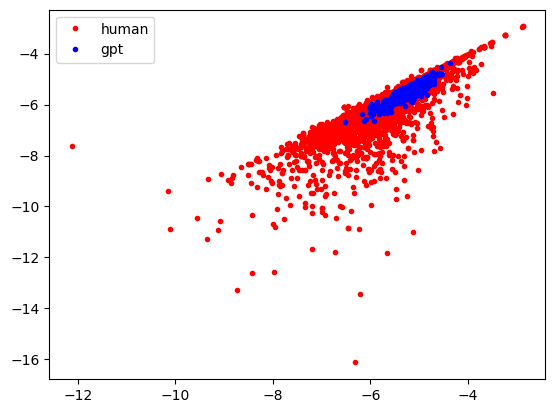

In [12]:
import matplotlib.pyplot as plt
# plt.scatter(all_human_scores[:, 2], all_human_scores[:, 3], c='r.')
# plt.scatter(all_gpt_scores[:, 2], all_gpt_scores[:, 3], c='b.')
plt.plot(all_human_scores[:, 2], all_human_scores[:, 3], 'r.')
plt.plot(all_gpt_scores[:, 2], all_gpt_scores[:, 3], 'b.')
plt.legend(['human', 'gpt'])
# 对于gpt分布而言，集中在比较中间的区域，然而对于单个评论，无法通过简要特征区分


In [52]:
print(len(glm_data_list))
all_glm_scores = np.array(all_glm_scores)

137


In [31]:
glm_entropy_scores = []
for i in range(len(glm_data_list)):
    glm_entropy_scores.append([
            compute_entropy(glm_data_list[i]['comment'], jieba_word_prob_dict),
            compute_entropy(glm_data_list[i]['comment'], ltp_word_prob_dict),
        ])
glm_entropy_scores = np.array(glm_entropy_scores)

In [16]:
# 筛选出500条人类评论
import random
index = list(range(len(all_human_scores)))
random.shuffle(index)
select_index = index[:500]
print(select_index)
select_human_data_list = [human_data_list[i] for i in select_index]
select_human_scores = all_human_scores[select_index]
json.dump(select_human_data_list, open(os.path.join(root_path, 'ExampleData/Comment/select_human_data_list.json'), 'w'), ensure_ascii = False)

[2782, 1582, 1090, 2971, 1026, 2243, 2556, 2279, 2575, 2953, 408, 1352, 102, 443, 1521, 1542, 2408, 674, 685, 618, 202, 1095, 476, 2482, 903, 895, 557, 1832, 121, 2639, 383, 1452, 2830, 1961, 2472, 480, 1813, 2784, 1604, 1280, 1700, 643, 1543, 1138, 533, 422, 1190, 2433, 1938, 1270, 497, 2660, 2372, 2287, 553, 1948, 2039, 2839, 994, 576, 49, 1192, 1047, 127, 1375, 910, 2958, 356, 1728, 462, 799, 1083, 1983, 662, 2689, 2603, 949, 1440, 343, 642, 2987, 1049, 1357, 2432, 248, 293, 2305, 1486, 2842, 972, 2666, 1299, 1627, 1601, 1776, 1284, 547, 2186, 551, 1602, 39, 2462, 1102, 2263, 2988, 1175, 2828, 454, 120, 691, 2677, 2418, 1241, 486, 2710, 2742, 90, 1194, 4, 2668, 1039, 1070, 1071, 2728, 734, 995, 2749, 337, 800, 2931, 1513, 494, 1453, 340, 1135, 2739, 2841, 822, 2808, 1527, 1420, 2594, 1870, 880, 145, 1928, 250, 1871, 2481, 1518, 1809, 2539, 302, 2932, 1401, 617, 546, 1806, 1528, 581, 2875, 1406, 150, 2941, 728, 1719, 1565, 124, 2257, 863, 2758, 1334, 2108, 2477, 603, 2166, 56, 2068, 

In [38]:
json.dump(select_human_data_list, open(os.path.join(root_path, 'ExampleData/Comment/select_human_data_list.json'), 'w'), ensure_ascii = False)
json.dump(select_human_scores.tolist(), open(os.path.join(root_path, 'Checkpoint/Comment/select_human_scores.json'), 'w'), ensure_ascii = False)
json.dump(select_index, open(os.path.join(root_path, 'Checkpoint/Comment/select_index.json'), 'w'), ensure_ascii = False)


In [47]:
def cal_statistic(data):
    avg = np.average(data)
    std = np.std(data)
    print('avg: ', avg, 'std: ', std)

# Entropy
cal_statistic(select_human_scores[:, 2])
cal_statistic(select_human_scores[:, 3])
cal_statistic(all_gpt_scores[:, 2])
cal_statistic(all_gpt_scores[:, 3])
cal_statistic(glm_entropy_scores[:, 0])
cal_statistic(glm_entropy_scores[:, 1])

avg:  -5.821561747550964 std:  0.9641930769837793
avg:  -6.294535439968109 std:  1.245380702361141
avg:  -5.207961736266146 std:  0.3228758607148351
avg:  -5.499219306473879 std:  0.3638287578681092
avg:  -5.775006987196199 std:  0.323128221995229
avg:  -6.0506217600813255 std:  0.3184724261940812


Text(0, 0.5, 'sentence length')

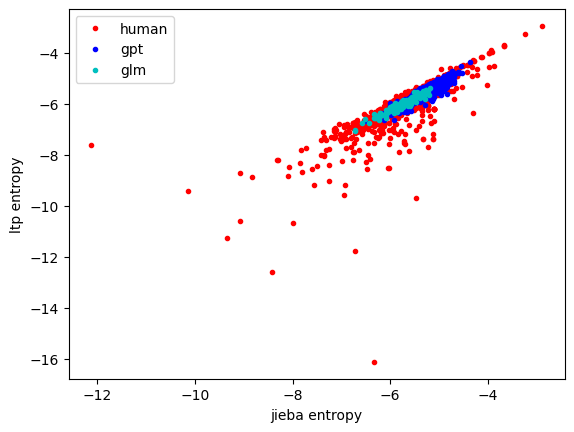

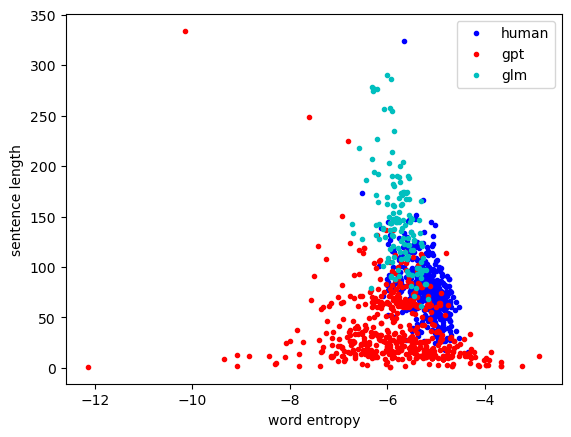

In [34]:
import matplotlib.pyplot as plt
human_sentence_len = [len(x['comment']) for x in select_human_data_list]
gpt_sentence_len = [len(x['comment']) for x in gpt_data_list]
glm_sentence_len = [len(x['comment']) for x in glm_data_list]
plt.figure()
plt.plot(select_human_scores[:, 2], select_human_scores[:, 3], 'r.')
plt.plot(all_gpt_scores[:, 2], all_gpt_scores[:, 3], 'b.')
plt.plot(glm_entropy_scores[:, 0], glm_entropy_scores[:, 1], 'c.')
plt.legend(['human', 'gpt', 'glm'])
plt.xlabel('jieba entropy')
plt.ylabel('ltp entropy')
# 对于分布而言，集中在比较中间的区域，然而对于单个评论，无法通过简要特征区分
plt.figure()
plt.plot(all_gpt_scores[:, 2], gpt_sentence_len, 'b.')
plt.plot(select_human_scores[:, 2], human_sentence_len, 'r.')
plt.plot(glm_entropy_scores[:, 0], glm_sentence_len, 'c.')
plt.legend(['human', 'gpt', 'glm'])
plt.xlabel('word entropy')
plt.ylabel('sentence length')
# 较强属性特征

Text(0, 0.5, 'T5 score')

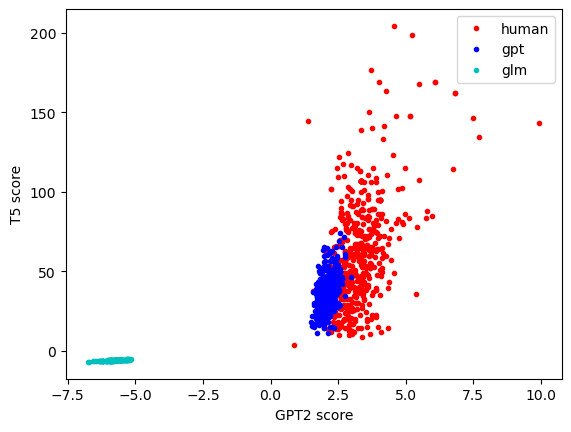

In [55]:
import matplotlib.pyplot as plt
human_sentence_len = [len(x['comment']) for x in select_human_data_list]
gpt_sentence_len = [len(x['comment']) for x in gpt_data_list]
glm_sentence_len = [len(x['comment']) for x in glm_data_list]
plt.figure()
plt.plot(select_human_scores[:, 0], select_human_scores[:, 1], 'r.')
plt.plot(all_gpt_scores[:, 0], all_gpt_scores[:, 1], 'b.')
plt.plot(glm_entropy_scores[:, 0], glm_entropy_scores[:, 1], 'c.')
plt.legend(['human', 'gpt', 'glm'])
plt.xlabel('GPT2 score')
plt.ylabel('T5 score')

In [56]:
t = '非常满意这次在京东购买的柑橘，果实新鲜，口感甜美，没有任何瑕疵。包装也非常精美，完全没有受损。而且，发货速度很快，比预计的时间提前了一天就送到了。总的来说，这是一次非常愉快的购物体验。会继续选择京东购物，也会向身边的朋友们推荐。非常感谢！'
print(compute_entropy(t, jieba_word_prob_dict))
t = '这次在京东购买的柑橘让我感到非常满意。果实新鲜，口感甜美，毫无瑕疵可言。包装也十分精致，没有任何损坏。更值得称赞的是发货速度，比预计的时间提前了一天就送到了。总体而言，这次购物体验非常愉快。我会继续选择京东购物，并且会向身边的朋友们推荐。非常感谢！'
print(compute_entropy(t, jieba_word_prob_dict))
t = '购买京东的柑橘让我非常满意。果实新鲜、口感甜美，无瑕疵，包装精美且完好无损。发货速度快，比预计时间提前一天送达。总体而言，这次购物体验非常愉快。我会继续选择京东购物，也会向朋友们推荐。非常感谢！'
print(compute_entropy(t, jieba_word_prob_dict))
t = '京东的配送速度，不论在何时，永远是两个字，效率，对此好评，且无可挑剔！商品与其包装也很好，多数情况下非常满意，就算不好也能及时解决！'
print(compute_entropy(t, jieba_word_prob_dict))
t = '京东的配送速度，无论何时，始终以两个字概括：高效。对此给予充分好评，简直是毫无可挑剔之处！商品及其包装也表现得相当出色，大多数情况下都让人非常满意。即便偶有不尽如人意之处，京东也能够及时解决问题，让人感到十分贴心。'
print(compute_entropy(t, jieba_word_prob_dict))
t = '京东的配送速度一直以高效著称，始终无可挑剔。商品和包装质量大多数情况下令人非常满意，即便出现问题，京东也能够及时解决。总体来说，京东在效率、商品质量和客户服务方面表现出色。'
print(compute_entropy(t, jieba_word_prob_dict))

-5.353727917254489
-5.715082065081643
-5.6433669471604855
-6.183767446321758
-7.0101629330666
-5.829491969159846


In [ ]:
import torch
import torch.nn as nn
class Model(nn.Module):   
    def __init__(self,feature_num):
        super(Model, self).__init__()        
        self.linear_layers = nn.Sequential(
            #nn.LazyLinear(512),
           nn.Linear(feature_num, feature_num), #41472 25088
           nn.ReLU(inplace=True),
            nn.Linear(feature_num, feature_num),
            nn.ReLU(inplace=True),
            nn.Linear(feature_num, feature_num),
            nn.ReLU(inplace=True),
            nn.Linear(feature_num, feature_num),
            nn.ReLU(inplace=True),
            nn.Linear(feature_num, 2),
        )
    
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x,y=None):
        hat_y = self.linear_layers(x)
        if not y ==None:
            loss = self.loss_fn(hat_y, y)
            return loss,hat_y
        else:
            return hat_y